# Text Classifiation

### Exploratory Data Analysis 


Imports that we need

In [1]:
import pandas as pd
import os 
from matplotlib import pyplot as plt
import seaborn as sns
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

We need to put this to stop kenrel from braking when I plot 

In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### Import the dataset

Download the dataset from : https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

In [3]:
data_folder = 'data'

os.listdir(data_folder)

['README', 'test', 'train']

List the directory structure

We want to see what polarity means in this context

In [4]:
polarity_df = pd.read_csv('./other-data/imdbEr.txt', header=None, names=['polarity'])
vocab_df = pd.read_csv('./other-data/imdb.vocab', header=None, names=['word'])


In [5]:
polarity_words_df = pd.merge(vocab_df, polarity_df, left_index=True, right_index=True)

In [6]:
polarity_words_df.sort_values(by='polarity', ascending=True)

,word,polarity
67306,subspace,-4.5
80133,bobbins,-4.5
46645,agis,-4.5
25509,wurb,-4.5
70915,schnass,-4.5
...,...,...
33815,double-d,4.5
70644,trestle,4.5
50326,grunner,4.5
33943,magorian,4.5


In [7]:
polarity_close_to_zero_filter = (polarity_words_df['polarity'] >= -0.001) & (polarity_words_df['polarity'] <= 0.001)
test_df = polarity_words_df[polarity_close_to_zero_filter]

In [8]:
test_df.sort_values(by='polarity')

,word,polarity
18702,mania,-0.000922
9137,elevate,-0.000898
35412,collin,-0.000827
4200,seed,-0.000801
10954,shields,-0.000781
...,...,...
10011,lambs,0.000730
6698,psychologist,0.000763
24151,stuffs,0.000799
20061,transplanted,0.000874


For now we can't deduce how the polarity is asigned to a word. On what crieteria is this decided. We need to further investigate

## Sentiment Analyisis
 We aim to do sentiment analysis on the reviews from imdb dataset and classify them into positive or negative reviews. The problem we face is a Binary classifier problem

First we need to grab the training, validation and testing data 

In [9]:
train_dir = os.path.join(data_folder, 'train')
test_dir = os.path.join(data_folder, 'test')

os.listdir(train_dir)

['neg', 'pos']

Let's see first how a review looks like:

In [10]:
def read_review(folder, file_name) -> str:
    file = os.path.join(folder, file_name)
    with open(file) as f:
        print(f.read())

positive_reviews_folder = os.path.join(train_dir, 'pos')

read_review(positive_reviews_folder, '0_9.txt')

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!


### Load the dataset

First I need to remove the unsupervised directory or move it somewhere else

In [11]:
batch_size = 32
seed = 42

def get_data(training_dir, testing_dir, batch_size, seed):
    
    raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
        training_dir,
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
        validation_split=0.2,
        subset='training'
    )

    raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
        training_dir,
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
        validation_split=0.2,
        subset='validation'
    )

    raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
        testing_dir,
        batch_size=batch_size,
    )

    return raw_train_ds, raw_val_ds, raw_test_ds


Grab the datasets

In [12]:
raw_train_ds, raw_val_ds, raw_test_ds = get_data(train_dir, test_dir, batch_size, seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


### Prepare the dataset for training

Here we need to standaridse the text, vectorize it, perform all kind of transformations over it

In [13]:
def remove_html_tags(text):
   br_clean = tf.strings.regex_replace(text, '<br />', ' ')
   clean_text = tf.strings.regex_replace(br_clean, '<[^>]*>', ' ')
   return clean_text

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = remove_html_tags(lowercase)
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [14]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [15]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [16]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [17]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))

first_review, first_label = text_batch[0], label_batch[0]

print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
text = custom_standardization(first_review)
print(text)
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

In [18]:
print("2 ---> ", vectorize_layer.get_vocabulary()[2])
print("1287 ---> ", vectorize_layer.get_vocabulary()[1287])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

2 --->  the
1287 --->  silent
Vocabulary size: 10000


We want to see the vocabulary

In [19]:
contor = 1

vocabulary = vectorize_layer.get_vocabulary()
for index, word in enumerate(vocabulary):
    print(f"{index} ---> {word}")
    contor+=1
    if contor == 100:
        break

0 ---> 
1 ---> [UNK]
2 ---> the
3 ---> and
4 ---> a
5 ---> of
6 ---> to
7 ---> is
8 ---> in
9 ---> it
10 ---> i
11 ---> this
12 ---> that
13 ---> was
14 ---> as
15 ---> for
16 ---> with
17 ---> movie
18 ---> but
19 ---> film
20 ---> on
21 ---> not
22 ---> you
23 ---> are
24 ---> his
25 ---> have
26 ---> be
27 ---> he
28 ---> one
29 ---> its
30 ---> all
31 ---> at
32 ---> by
33 ---> an
34 ---> they
35 ---> from
36 ---> who
37 ---> so
38 ---> like
39 ---> her
40 ---> just
41 ---> or
42 ---> about
43 ---> has
44 ---> out
45 ---> if
46 ---> some
47 ---> there
48 ---> what
49 ---> good
50 ---> more
51 ---> when
52 ---> very
53 ---> even
54 ---> my
55 ---> she
56 ---> up
57 ---> no
58 ---> time
59 ---> would
60 ---> which
61 ---> only
62 ---> really
63 ---> story
64 ---> their
65 ---> were
66 ---> had
67 ---> see
68 ---> can
69 ---> me
70 ---> than
71 ---> we
72 ---> much
73 ---> well
74 ---> been
75 ---> get
76 ---> will
77 ---> also
78 ---> other
79 ---> people
80 ---> bad
81 ---> into
82 

### Vectorize and standardize the datasets

In [20]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance to use cache

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

In [22]:
# This is an integer indicating the dimensionality of the embedding space. It determines the size of the embedding vectors. For example, 
# if embedding_dim is set to 16, each word in the vocabulary will be represented by a dense vector of length 16

embedding_dim = 16

baseline_model = [
    layers.Embedding(max_features, embedding_dim),
    layers.Dropout(0.5),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
]

model = tf.keras.Sequential(baseline_model)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,017
Trainable params: 160,017
Non-trainable params: 0
__________________________________________________

### Compile the model

In [23]:
model.compile(loss=losses.BinaryCrossentropy(), optimizer='adam', metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

### Train the model

In [24]:
epochs = 15

history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/15


625/625 [==============================] - 9s 12ms/step - loss: 0.6753 - binary_accuracy: 0.6629 - val_loss: 0.6439 - val_binary_accuracy: 0.7544
Epoch 2/15
625/625 [==============================] - 4s 6ms/step - loss: 0.5936 - binary_accuracy: 0.7741 - val_loss: 0.5489 - val_binary_accuracy: 0.8012
Epoch 3/15
625/625 [==============================] - 3s 6ms/step - loss: 0.5052 - binary_accuracy: 0.8165 - val_loss: 0.4717 - val_binary_accuracy: 0.8304
Epoch 4/15
625/625 [==============================] - 4s 6ms/step - loss: 0.4375 - binary_accuracy: 0.8441 - val_loss: 0.4181 - val_binary_accuracy: 0.8500
Epoch 5/15
625/625 [==============================] - 4s 6ms/step - loss: 0.3924 - binary_accuracy: 0.8598 - val_loss: 0.3826 - val_binary_accuracy: 0.8582
Epoch 6/15
625/625 [==============================] - 4s 6ms/step - loss: 0.3586 - binary_accuracy: 0.8713 - val_loss: 0.3574 - val_binary_accuracy: 0.8646
Epoch 7/15
625/625 [==============================] - 4s 6ms/step - loss: 

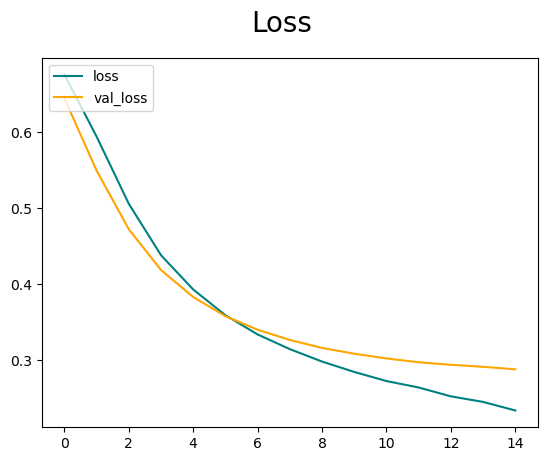

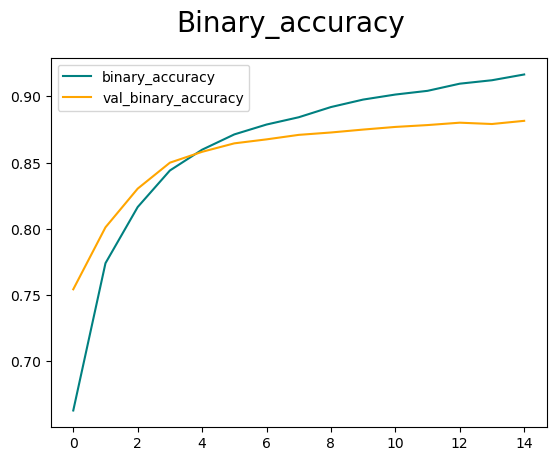

In [25]:
history_metrics = history.history

def plot_metrics(history, metric):
    if metric not in history:
        raise ValueError(f"{metric} not found in history. Available metrics: {', '.join(history.keys())}")
    
    fig = plt.figure()
    plt.plot(history[metric], color='teal', label=metric)
    val_metric = 'val_' + metric
    plt.plot(history[val_metric], color='orange', label=val_metric)
    fig.suptitle(metric.capitalize(), fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

plot_metrics(history_metrics, metric='loss')
plot_metrics(history_metrics, metric='binary_accuracy') 

We can notice that the model is overfitting now

### Evaluate the model

In [26]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 42s 53ms/step - loss: 0.3075 - binary_accuracy: 0.8747
Loss:  0.30746015906333923
Accuracy:  0.8746799826622009


### Test on new data

In [27]:
examples_raw = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
])


# Assuming labels are available, create a dummy labels tensor for demonstration
labels = tf.constant([1, 1, 0])

# Use tf.data.Dataset.from_tensor_slices to create a dataset from examples_raw and labels
dataset = tf.data.Dataset.from_tensor_slices((examples_raw, labels))

# Use map to apply vectorize_text_fn to each element of the dataset
examples = dataset.map(vectorize_text)

model.predict(examples)

3/3 [==============================] - 0s 4ms/step


array([[0.63569874],
       [0.4518583 ],
       [0.36206797]], dtype=float32)

### Find the average number of words per review

In [ ]:
text_batch, label_batch = next(iter(raw_train_ds))

In [51]:

first_review = text_batch[0]
print("Review", type(first_review))

Review <class 'tensorflow.python.framework.ops.EagerTensor'>


In [141]:
review_indices = []
num_words = []
number_of_reviews = 0

for i, (text_batch, _) in enumerate(raw_train_ds):
    for j, review in enumerate(text_batch.numpy()):
        review_indices.append(number_of_reviews)
        num_words.append(len(review.split()))
        number_of_reviews +=1


True

Now we must creat a dataset with the index of the review and the number of words in that review, and we can find the average number of reviews and plot their distribution

In [146]:
# Create a DataFrame
reviews_df = pd.DataFrame({'num_words': num_words})

# Display the DataFrame
reviews_df.describe()

,num_words
count,20000.000000
mean,232.518300
std,172.742538
min,10.000000
25%,127.000000
50%,174.000000
75%,281.000000
max,2470.000000


In [153]:
# Calculate the 90th percentile
percentile_90 = reviews_df['num_words'].quantile(0.9)

print("90th percentile of num_words column:", percentile_90)

90th percentile of num_words column: 454.1000000000022


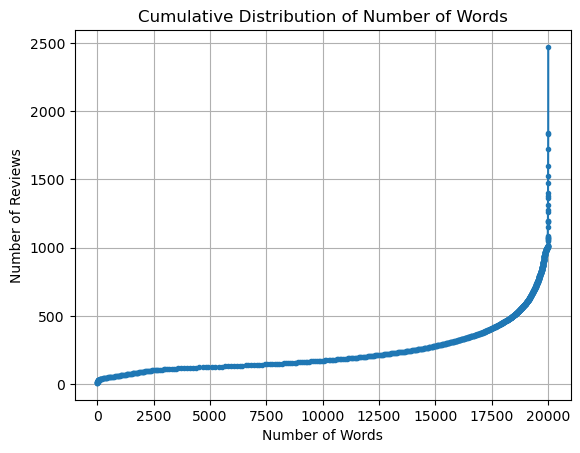

In [158]:
# Sort the DataFrame by the 'num_words' column
reviews_df_sorted = reviews_df.sort_values(by='num_words')

# Calculate the cumulative distribution
cumulative_distribution = (reviews_df_sorted
                            .reset_index(drop=True)
                            .reset_index()
                            .groupby('num_words')
                            .count()
                            .cumsum())

# Plot the line plot
plt.plot(cumulative_distribution['index'], cumulative_distribution.index,  marker='.')
plt.title('Cumulative Distribution of Number of Words')
plt.xlabel('Number of Words')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

C:\Users\Hori\AppData\Local\Temp\ipykernel_13904\1667288571.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  word_bins_count = reviews_df.groupby('word_bins').size()


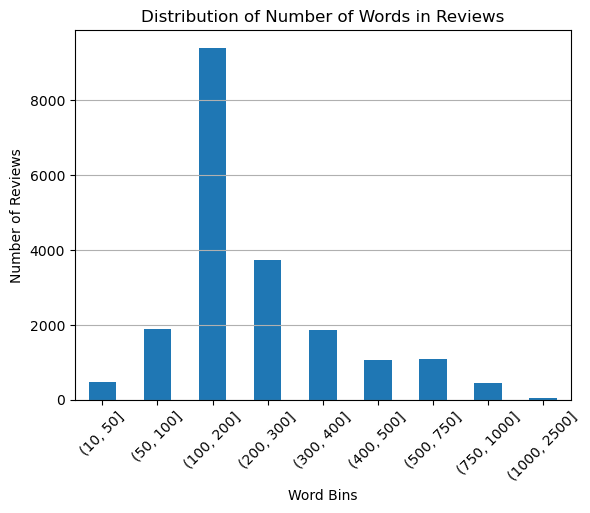

In [164]:
bins = [10, 50, 100, 200, 300, 400, 500, 750, 1000, 2500]  # Define your own bins as needed

# Bin the number of words
reviews_df['word_bins'] = pd.cut(reviews_df['num_words'], bins=bins)

# Group by the word bins and count the number of reviews in each bin
word_bins_count = reviews_df.groupby('word_bins').size()

# Plot the bar plot
word_bins_count.plot(kind='bar')
plt.title('Distribution of Number of Words in Reviews')
plt.xlabel('Word Bins')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')
plt.show()

From this we can conclude that around 250 number of tokens per vector is a correct assumption

### Understaning how vocabulary works

Here we just played a bit with creating a smaller vocabulary to see how it works

In [97]:
examples_raw = tf.constant([
  "The movie was great !",
  "The movie was okay.",
  "The movie was terrible..."
])


# Assuming labels are available, create a dummy labels tensor for demonstration
labels = tf.constant([1, 1, 0])

# Use tf.data.Dataset.from_tensor_slices to create a dataset from examples_raw and labels
dataset = tf.data.Dataset.from_tensor_slices((examples_raw, labels))


dataset_text_only = dataset.map(lambda example, label: example)

# Specify the batch size
batch_size = 1
# Create batches of examples ignoring labels
batched_dataset = dataset_text_only.batch(batch_size)
train_text = batched_dataset.map(lambda x: x)
vectorize_layer.adapt(train_text)

text_batch = next(iter(batched_dataset))


first_review = text_batch[0]

print("Review", first_review)
print("Vectorized review", vectorize_text(first_review, 1))

contor = 1

vocabulary = vectorize_layer.get_vocabulary()
for index, word in enumerate(vocabulary):
    print(f"{index} ---> {word}")
    contor+=1
    if contor == 100:
        break

### Visualizing the word embeddings

[[ 2.2303900e-03  5.1602721e-03  7.7693723e-03 ...  1.3966043e-02
   4.1435468e-03  2.0238975e-04]
 [-2.3699515e-02  1.8035451e-02  1.6662950e-02 ... -2.9314293e-02
   2.7308857e-02  1.8968070e-02]
 [-9.0861432e-03 -3.8307238e-02 -9.5199563e-02 ...  1.9002132e-02
  -2.1852884e-02 -6.1196480e-02]
 ...
 [-3.2286066e-01  2.0607023e-01  4.2802039e-01 ... -1.9289960e-01
   3.5664868e-01  2.0239480e-01]
 [-8.4378868e-02  8.2314700e-02  1.9423586e-01 ... -5.0272577e-02
   4.2458652e-03  6.7678802e-02]
 [-3.4071565e-01  2.0143716e-01  2.1393535e-01 ... -2.7553633e-01
   1.7450809e-01  2.8752863e-01]]


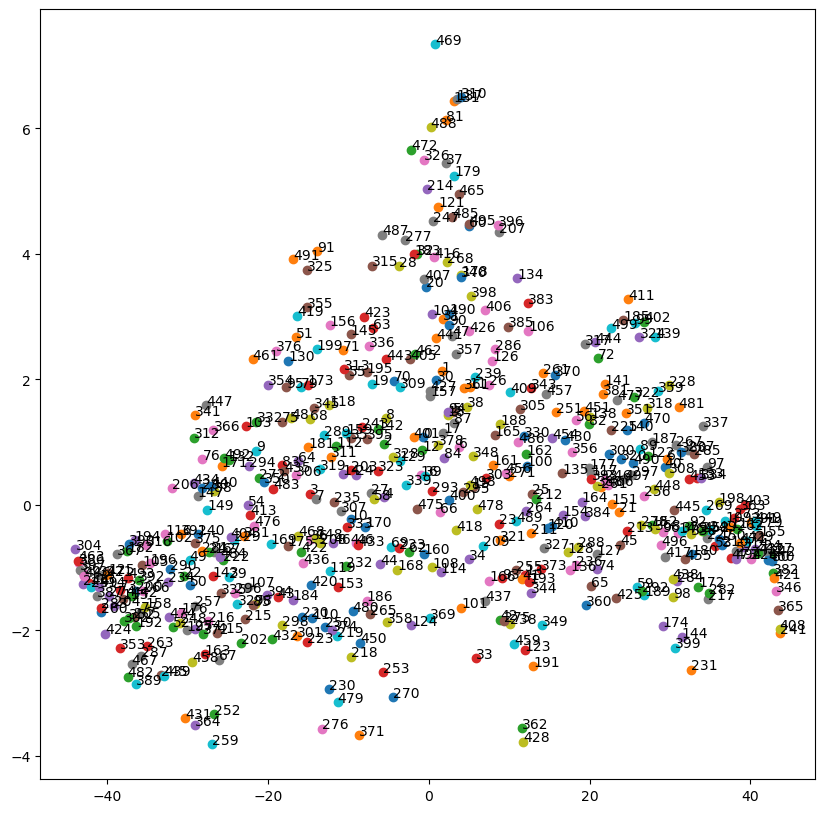

In [56]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Assuming 'embedding_layer' is the embedding layer of your model
embedding_matrix = model.layers[0].get_weights()[0]

# Extract a subset of word embeddings for visualization (optional)
num_words_to_visualize = 500
embedding_matrix_subset = embedding_matrix[:num_words_to_visualize]

print(embedding_matrix_subset)

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(embedding_matrix_subset)

# Visualize the word embeddings in 2D
plt.figure(figsize=(10, 10))
for i in range(len(embeddings_2d)):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
    plt.annotate(str(i), (embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.show()